# Parsing DarkMachine csv files

Parsing tutorials:
* https://www.vipinajayakumar.com/parsing-text-with-python/
  * code: https://github.com/bluprince13/parsing_text_with_python/blob/master/complex_text_parsing.py
* regexp howto: https://docs.python.org/3/howto/regex.html
* https://tomassetti.me/parsing-in-python/

## Darkmachines

Samples
* LHC simulated datasets from the https://darkmachines.org/ website: https://zenodo.org/record/3685861#.YLSWIBE6_mF
(local disk: /AtlasDisk/user/donini/ATLAS/DarkMachines)

* Hackathon dataset from https://www.phenomldata.org/: https://zenodo.org/record/3961917#.YLSR1RE6_mE

* Secret dataset: https://zenodo.org/record/4443151#.YLSSHRE6_mE

The description of the samples:
* original description is given section 23 (p194+) of the Les Houches 2019 paper: https://arxiv.org/abs/2002.12220
* Hackathon dataset: https://zenodo.org/record/3961917#.YLSR1RE6_mE

Details about the generation:
* generation cards (see Delphes for object selection): https://github.com/melli1992/unsupervised_darkmachines
* generated processes: https://docs.google.com/document/d/1N1yetfbXXnAqNb1CIT-ajIKh1EQW2GB8N4Z9HrMAREQ/edit

Symbol ids: j, b, e-, e+, m-, m+, g

Data format: event ID; process ID; event weight; MET; METphi; obj1, E1, pt1, eta1,phi1; obj2, E2, pt2, eta2, phi2;...

Energies are in MeV

Paper:
* https://arxiv.org/abs/2105.14027

Results:
* https://github.com/bostdiek/DarkMachines-UnsupervisedChallenge

In [1]:
import numpy as np
import pandas as pd
import re
from pathlib import Path
import matplotlib.pyplot as plt

## Available files

In [2]:
### Nfiles corresponding to 10fb (weights=1)
bsm_files_10fb = ['gluino_01_10fb.csv', 'gluino_02_10fb.csv', 'gluino_03_10fb.csv', 'gluino_04_10fb.csv',
'gluino_05_10fb.csv', 'gluino_06_10fb.csv', 'gluino_07_10fb.csv', 'stop_01_10fb.csv',
'stop_02_10fb.csv', 'stop_03_10fb.csv', 'stop_04_10fb.csv', 'Zp_technicol_01_10fb.csv',
'Zp_technicol_02_10fb.csv', 'Zp_technicol_03_10fb.csv', 'Zp_technicol_04_10fb.csv',
'Zp_technicol_05_10fb.csv']

### More generated events (weights<1)
bsm_files_full = ['gluino_01_p_p_to_go_go_0_0.2013275_21.csv',
'gluino_02_p_p_to_go_go_0_0.0508105_30.csv',
'gluino_03_p_p_to_go_go_0_0.0144098_39.csv',
'gluino_04_p_p_to_go_go_0_0.00442036_48.csv',
'gluino_05_p_p_to_go_go_0_0.00143275_84.csv',
'gluino_06_p_p_to_go_go_0_0.0004843405_66.csv',
'gluino_07_p_p_to_go_go_0_0.000168185_75.csv',
'stop_01_p_p_to_t1_t1~0_26.7494500003_39.csv',
'stop_02_p_p_to_t1_t1~0_5.69774999996_48.csv',
'stop_03_p_p_to_t1_t1~0_1.2483025_75.csv',
'stop_04_p_p_to_t1_t1~0_0.0200922000001_84.csv', 'Zp_technicol_01_0.3865.csv',
'Zp_technicol_02_0.12206.csv', 'Zp_technicol_03_0.044272.csv',
'Zp_technicol_04_0.017957.csv', 'Zp_technicol_05_0.00807869999999.csv']

### Nfiles corresponding to 10fb (weights=1)
sm_files_10fb = ['2gam_10fb.csv', '4top_10fb.csv', 'atop_10fb.csv', 'atopbar_10fb.csv',
'gam_jets_10fb.csv', 'njets_10fb.csv', 'single_higgs_10fb.csv', 'single_top_10fb.csv',
'single_topbar_10fb.csv', 'ttbar_10fb.csv', 'ttbarGam_10fb.csv', 'ttbarHiggs_10fb.csv',
'ttbarW_10fb.csv', 'ttbarWW_10fb.csv', 'ttbarZ_10fb.csv', 'Wgam_10fb.csv',
'w_jets_10fb.csv', 'wtop_10fb.csv', 'wtopbar_10fb.csv', 'ww_10fb.csv', 'Zgam_10fb.csv',
'z_jets_10fb.csv', 'ztop_10fb.csv', 'ztopbar_10fb.csv', 'zw_10fb.csv', 'zz_10fb.csv']

# --> selected processes more relevant to top analyses (but no QCD, no 4top)
sm_files_10fb_top_noqcd = ['single_top_10fb.csv', 'single_topbar_10fb.csv', 'ttbar_10fb.csv','ttbarW_10fb.csv', 'ttbarWW_10fb.csv', 'ttbarZ_10fb.csv', 'w_jets_10fb.csv', 'wtop_10fb.csv', 'wtopbar_10fb.csv', 'ww_10fb.csv', 'Zgam_10fb.csv','z_jets_10fb.csv', 'ztop_10fb.csv', 'ztopbar_10fb.csv', 'zw_10fb.csv', 'zz_10fb.csv']

# --> process gamma-gamma + Higgs (no QCD, no top)
sm_files_10fb_gamma_noqcd = ['2gam_10fb.csv','gam_jets_10fb.csv','single_higgs_10fb.csv','Wgam_10fb.csv','Zgam_10fb.csv']

### More generated events w/ at least 20000 lines (weights<1)
sm_files_min20000 = ['4top_min20000_0.0096595986.csv', 'atopbar_min20000_0.270715462961.csv',
'atop_min20000_0.394719941825.csv', 'single_higgs_min20000_1.93837414875.csv',
'ttbarGam_min20000_1.547189548.csv', 'ttbarHiggs_min20000_0.45681409215.csv',
'ttbarW_min20000_0.34959.csv', 'ttbarWW_min20000_0.0085169756.csv',
'ttbarZ_min20000_0.5874599.csv', 'ztopbar_min20000_0.15244566525.csv',
'ztop_min20000_0.255457848625.csv']

# Higgs more stat (weight<1)
sm_files_min20000_Higgs = ['single_higgs_min20000_1.93837414875.csv']

## New datasets: hackathon and secret

In [3]:
### Hackathon: "../Data/DarkMachines/hackathon"
hack_chan1 = ['background_chan1_7.79.csv','glgl1400_neutralino1100_chan1.csv','glgl1600_neutralino800_chan1.csv','monojet_Zp2000.0_DM_50.0_chan1.csv','monotop_200_A_chan1.csv','sqsq1_sq1400_neut800_chan1.csv','sqsq_sq1800_neut800_chan1.csv','stlp_st1000_chan1.csv','stop2b1000_neutralino300_chan1.csv']
hack_chan2a = ['background_chan2a_309.6.csv','chaneut_cha200_neut50_chan2a.csv','chaneut_cha250_neut150_chan2a.csv','chaneut_cha300_neut100_chan2a.csv','chaneut_cha400_neut200_chan2a.csv','gluino_1000.0_neutralino_1.0_chan2a.csv','pp23mt_50_chan2a.csv','pp24mt_50_chan2a.csv']
hack_chan2b = ['background_chan2b_7.8.csv','chacha_cha300_neut140_chan2b.csv','chacha_cha400_neut60_chan2b.csv','chacha_cha600_neut200_chan2b.csv','chaneut_cha200_neut50_chan2b.csv','chaneut_cha250_neut150_chan2b.csv','gluino_1000.0_neutralino_1.0_chan2b.csv','pp23mt_50_chan2b.csv','pp24mt_50_chan2b.csv','stlp_st1000_chan2b.csv']
hack_chan3  = ['background_chan3_8.02.csv','glgl1400_neutralino1100_chan3.csv','glgl1600_neutralino800_chan3.csv','gluino_1000.0_neutralino_1.0_chan3.csv','monojet_Zp2000.0_DM_50.0_chan3.csv','monotop_200_A_chan3.csv','monoV_Zp2000.0_DM_1.0_chan3.csv','sqsq1_sq1400_neut800_chan3.csv','sqsq_sq1800_neut800_chan3.csv','stlp_st1000_chan3.csv','stop2b1000_neutralino300_chan3.csv']

### Secret dataset: "../Data/DarkMachines/secret_dataset"
secret_chan1 = ['unlabeled_combined_chan1.csv']
secret_chan2a = ['unlabeled_combined_chan2a.csv']
secret_chan2b = ['unlabeled_combined_chan2b.csv']
secret_chan3 = ['unlabeled_combined_chan3.csv']

# Details samples
#chan1: >=4 jets, high Ht (bckgd 214k evts: 88% njets, 5% ttbar, 5% W/Z+jets, 1% Wtop)
#chan2a: 3 leptons, MET (low stat)
#chan2b: 2 leptons, MET, Ht
#chan3: Ht, MET

## File to process and selection

WARNING: W/γ/Z+jets and QCD jet production have applied cuts on HT > 100 GeV and 600 GeV, respectively


### SM

In [4]:
### SM
#DATAPATH="../Data/DarkMachines/sm"
#DATAPATH="../Data/DarkMachines/sm/min_20000"
DATAPATH="../Data/DarkMachines/hackathon/chan3"

### Process list of files
#files_to_process = sm_files_10fb_top_noqcd
#files_to_process = sm_files_10fb_gamma_noqcd
#files_to_process = sm_files_min20000_Higgs
files_to_process = hack_chan3

### Test
#files_to_process = ['wtop_10fb.csv']
#files_to_process = ['ttbar_10fb.csv']

### BSM

### Event selection
Event selection array of the form [N jets, N b-jets, N electrons, N muons, N photons]

In [5]:
### ttbar-like
#selection=([2,2,1,0,0],[2,2,0,1,0]) 
#selection=([3,1,1,0,0],[3,1,0,1,0])
#selection=([4,0,1,0,0],[4,0,0,1,0]) 

### single-top like
#selection=([0,2,1,0,0],[0,2,0,1,0]) 

### gamma-gamma
#selection=([0,0,0,0,2],[1,0,0,0,2]) 
#selection=[[2,0,0,0,2]] # gamma-gamma

### chan1
#selection=[[5,0,0,0,0],[4,0,0,0,0],[3,1,0,0,0],[2,2,0,0,0],[3,1,1,0,0],[3,1,0,1,0],[2,2,1,0,0],[2,2,0,1,0]]
#selection=[[6,0,0,0,0],[5,0,0,0,0],[4,1,0,0,0],[3,2,0,0,0],[4,1,1,0,0],[4,1,0,1,0],[3,2,1,0,0],[3,2,0,1,0]]

#selection=[[8,0,0,0,0],[7,0,0,0,0],[6,0,0,0,0],[5,0,0,0,0],[4,0,0,0,0],
#           [7,1,0,0,0],[6,1,0,0,0],[5,1,0,0,0],[4,1,0,0,0],[3,1,0,0,0]]

#selection=[[5,0,0,0,0],[4,1,0,0,0],[3,2,0,0,0],[4,1,1,0,0],[4,1,0,1,0],[3,2,1,0,0],[3,2,0,1,0]]

In [6]:
### CHAN3: ttbar-like selection
# N objects of each type [MIN,MAX]

NJETS=[6,7] # done 1(partial), 2-5
NBJETS=[0,2]
NELEC=[0,1]
NMUON=[0,1]
NGAMMA=[0,0]

selection=[]
nsel = 0
for nj in range(NJETS[0],NJETS[1]+1):
    for nb in range(NBJETS[0],NBJETS[1]+1):
        for ne in range(NELEC[0],NELEC[1]+1):
            for nm in range(NMUON[0],NMUON[1]+1):
                for ng in range(NGAMMA[0],NGAMMA[1]+1):
                    #print(nj,nb,ne,nm,ng)
                    selection += [[nj,nb,ne,nm,ng]]
                    nsel += 1
print(nsel)
print(selection)

24
[[6, 0, 0, 0, 0], [6, 0, 0, 1, 0], [6, 0, 1, 0, 0], [6, 0, 1, 1, 0], [6, 1, 0, 0, 0], [6, 1, 0, 1, 0], [6, 1, 1, 0, 0], [6, 1, 1, 1, 0], [6, 2, 0, 0, 0], [6, 2, 0, 1, 0], [6, 2, 1, 0, 0], [6, 2, 1, 1, 0], [7, 0, 0, 0, 0], [7, 0, 0, 1, 0], [7, 0, 1, 0, 0], [7, 0, 1, 1, 0], [7, 1, 0, 0, 0], [7, 1, 0, 1, 0], [7, 1, 1, 0, 0], [7, 1, 1, 1, 0], [7, 2, 0, 0, 0], [7, 2, 0, 1, 0], [7, 2, 1, 0, 0], [7, 2, 1, 1, 0]]


## Set up regular expressions

In [7]:
# use https://regexper.com to visualise these if required
rx_dict = {
    #'jets': re.compile(r'j,(?P<jets>.*,.*,.*,.*;)\n')
    'header': re.compile(r'(?P<id>\d+);(?P<name>.*?);(?P<weight>.*?);(?P<MET>.*?);(?P<METphi>.*?);'),
    'jets': re.compile('j,(.*?),(.*?),(.*?),(.*?);'),
    'b-jets': re.compile('b,(.*?),(.*?),(.*?),(.*?);'),
    'elec': re.compile('e.,(.*?),(.*?),(.*?),(.*?);'),
    'muons': re.compile('m.,(.*?),(.*?),(.*?),(.*?);'),
    'gamma': re.compile('g,(.*?),(.*?),(.*?),(.*?);')
}
#rx_dict

def get_header(name,line):
    key = rx_dict.get(name)
    if key:
        header = rx_dict[name].match(line)
        header_new = [int(header.group('id')),header.group('name'),float(header.group('weight')),float(header.group('MET')),float(header.group('METphi'))]
        return header_new
    else:
        print("Warning: '%s' name not found in dictionary" % name )
    return None


def get_particles(name,line):
    key = rx_dict.get(name)
    npart = 0
    if key:
        particles = rx_dict[name].findall(line)
        if particles:
            part = np.array(particles).astype(np.float)
            npart = part.shape[0]
            return part, npart
    else:
        print("Warning: '%s' name not found in dictionary" % name )
    return None, npart

## Loop on file and dump selected particles in dataframe

In [8]:
def process_file(filepath, selection):
    '''
    filepath : filename
    selection: array of the form [nj,nb,ne,nm,ng]
    '''
    
    # create an empty list to collect the data
    data = []
    count = 0 # count total lines
    
    # open the file and read through it line by line
    #file_object= open(filepath,'r')
    #Nlines = len(file_object.readlines())
    #file_object.seek(0, 0) # Go back to beginning of file
    
    with open(filepath,'r') as file_object:
        for line in file_object:
            count += 1
            
            # Get header
            header = get_header('header',line)
    
            # Get particles
            jets,  nj = get_particles('jets',line)
            bjets, nb = get_particles('b-jets',line)
            elec,  ne = get_particles('elec',line)
            muons, nm = get_particles('muons',line)
            gamma, ng = get_particles('gamma',line)
            #print('found %d jets, %d bjets, %d elec, %d muons, %d gammas' % (nj,nb,ne,nm,ng))
 
            # tuples with all particles and numbers
            particles  =(jets,bjets,elec,muons,gamma)
            nparticles = (nj,nb,ne,nm,ng)
        
            if (not header): continue

            row = np.array(header)

            evt_selection_flag = True
            for j in range(5):
                if ( nparticles[j]==selection[j] ):
                    if ( nparticles[j]>0 ): 
                        row = np.concatenate((row,particles[j].flatten()))                
                else:
                    evt_selection_flag = False
                    continue

            # Save event
            if ( evt_selection_flag): 
                data.append(row)
                #print(line)
                #print('    saved event: %d jets, %d bjets, %d elec, %d muons, %d gammas' % (nj,nb,ne,nm,ng))

    # Store in df
    df = pd.DataFrame(data)
    print('  --> selected %d / %d events (=%.1f%%) [%d features]' % (df.shape[0], count, (100*df.shape[0]/count) , df.shape[1]))
    return df, count

## Save file

In [9]:
def savefile(filename,selection,df):
    nj,nb,ne,nm,ng = selection
    dirname="%s/selections/channels_%dj%db%de%dm%dg" % (DATAPATH,nj,nb,ne,nm,ng)

    # Create output dir
    Path(dirname).mkdir(parents=True, exist_ok=True)

    # output file
    outfile=dirname+"/"+filename
    df.to_csv(outfile,index=False)

## Process file(s)

And make pie-charts

In [10]:
pienorm=True

../Data/DarkMachines/hackathon/chan3/background_chan3_8.02.csv [6, 0, 0, 0, 0]


<ipython-input-7-164dbfe73309>:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  part = np.array(particles).astype(np.float)


  --> selected 665805 / 8544111 events (=7.8%) [29 features]
../Data/DarkMachines/hackathon/chan3/background_chan3_8.02.csv [6, 0, 0, 1, 0]
  --> selected 2509 / 8544111 events (=0.0%) [33 features]
../Data/DarkMachines/hackathon/chan3/background_chan3_8.02.csv [6, 0, 1, 0, 0]
  --> selected 1061 / 8544111 events (=0.0%) [33 features]
../Data/DarkMachines/hackathon/chan3/background_chan3_8.02.csv [6, 0, 1, 1, 0]
  --> selected 16 / 8544111 events (=0.0%) [37 features]
../Data/DarkMachines/hackathon/chan3/background_chan3_8.02.csv [6, 1, 0, 0, 0]
  --> selected 89913 / 8544111 events (=1.1%) [33 features]
../Data/DarkMachines/hackathon/chan3/background_chan3_8.02.csv [6, 1, 0, 1, 0]
  --> selected 1720 / 8544111 events (=0.0%) [37 features]
../Data/DarkMachines/hackathon/chan3/background_chan3_8.02.csv [6, 1, 1, 0, 0]
  --> selected 680 / 8544111 events (=0.0%) [37 features]
../Data/DarkMachines/hackathon/chan3/background_chan3_8.02.csv [6, 1, 1, 1, 0]
  --> selected 31 / 8544111 events

  --> selected 0 / 17484 events (=0.0%) [0 features]
../Data/DarkMachines/hackathon/chan3/glgl1600_neutralino800_chan3.csv [7, 0, 0, 0, 0]
  --> selected 2305 / 17484 events (=13.2%) [33 features]
../Data/DarkMachines/hackathon/chan3/glgl1600_neutralino800_chan3.csv [7, 0, 0, 1, 0]
  --> selected 0 / 17484 events (=0.0%) [0 features]
../Data/DarkMachines/hackathon/chan3/glgl1600_neutralino800_chan3.csv [7, 0, 1, 0, 0]
  --> selected 1 / 17484 events (=0.0%) [37 features]
../Data/DarkMachines/hackathon/chan3/glgl1600_neutralino800_chan3.csv [7, 0, 1, 1, 0]
  --> selected 0 / 17484 events (=0.0%) [0 features]
../Data/DarkMachines/hackathon/chan3/glgl1600_neutralino800_chan3.csv [7, 1, 0, 0, 0]
  --> selected 309 / 17484 events (=1.8%) [37 features]
../Data/DarkMachines/hackathon/chan3/glgl1600_neutralino800_chan3.csv [7, 1, 0, 1, 0]
  --> selected 1 / 17484 events (=0.0%) [41 features]
../Data/DarkMachines/hackathon/chan3/glgl1600_neutralino800_chan3.csv [7, 1, 1, 0, 0]
  --> selected 0 

  --> selected 1 / 6399 events (=0.0%) [41 features]
../Data/DarkMachines/hackathon/chan3/monojet_Zp2000.0_DM_50.0_chan3.csv [7, 2, 0, 1, 0]
  --> selected 0 / 6399 events (=0.0%) [0 features]
../Data/DarkMachines/hackathon/chan3/monojet_Zp2000.0_DM_50.0_chan3.csv [7, 2, 1, 0, 0]
  --> selected 0 / 6399 events (=0.0%) [0 features]
../Data/DarkMachines/hackathon/chan3/monojet_Zp2000.0_DM_50.0_chan3.csv [7, 2, 1, 1, 0]
  --> selected 0 / 6399 events (=0.0%) [0 features]
../Data/DarkMachines/hackathon/chan3/monotop_200_A_chan3.csv [6, 0, 0, 0, 0]
  --> selected 352 / 7261 events (=4.8%) [29 features]
../Data/DarkMachines/hackathon/chan3/monotop_200_A_chan3.csv [6, 0, 0, 1, 0]
  --> selected 9 / 7261 events (=0.1%) [33 features]
../Data/DarkMachines/hackathon/chan3/monotop_200_A_chan3.csv [6, 0, 1, 0, 0]
  --> selected 5 / 7261 events (=0.1%) [33 features]
../Data/DarkMachines/hackathon/chan3/monotop_200_A_chan3.csv [6, 0, 1, 1, 0]
  --> selected 0 / 7261 events (=0.0%) [0 features]
../Dat

  --> selected 3 / 7632 events (=0.0%) [41 features]
../Data/DarkMachines/hackathon/chan3/sqsq1_sq1400_neut800_chan3.csv [6, 2, 1, 0, 0]
  --> selected 2 / 7632 events (=0.0%) [41 features]
../Data/DarkMachines/hackathon/chan3/sqsq1_sq1400_neut800_chan3.csv [6, 2, 1, 1, 0]
  --> selected 0 / 7632 events (=0.0%) [0 features]
../Data/DarkMachines/hackathon/chan3/sqsq1_sq1400_neut800_chan3.csv [7, 0, 0, 0, 0]
  --> selected 889 / 7632 events (=11.6%) [33 features]
../Data/DarkMachines/hackathon/chan3/sqsq1_sq1400_neut800_chan3.csv [7, 0, 0, 1, 0]
  --> selected 98 / 7632 events (=1.3%) [37 features]
../Data/DarkMachines/hackathon/chan3/sqsq1_sq1400_neut800_chan3.csv [7, 0, 1, 0, 0]
  --> selected 90 / 7632 events (=1.2%) [37 features]
../Data/DarkMachines/hackathon/chan3/sqsq1_sq1400_neut800_chan3.csv [7, 0, 1, 1, 0]
  --> selected 1 / 7632 events (=0.0%) [41 features]
../Data/DarkMachines/hackathon/chan3/sqsq1_sq1400_neut800_chan3.csv [7, 1, 0, 0, 0]
  --> selected 146 / 7632 events (=1.

  --> selected 16 / 33397 events (=0.0%) [49 features]
../Data/DarkMachines/hackathon/chan3/stop2b1000_neutralino300_chan3.csv [6, 0, 0, 0, 0]
  --> selected 287 / 9287 events (=3.1%) [29 features]
../Data/DarkMachines/hackathon/chan3/stop2b1000_neutralino300_chan3.csv [6, 0, 0, 1, 0]
  --> selected 30 / 9287 events (=0.3%) [33 features]
../Data/DarkMachines/hackathon/chan3/stop2b1000_neutralino300_chan3.csv [6, 0, 1, 0, 0]
  --> selected 23 / 9287 events (=0.2%) [33 features]
../Data/DarkMachines/hackathon/chan3/stop2b1000_neutralino300_chan3.csv [6, 0, 1, 1, 0]
  --> selected 1 / 9287 events (=0.0%) [37 features]
../Data/DarkMachines/hackathon/chan3/stop2b1000_neutralino300_chan3.csv [6, 1, 0, 0, 0]
  --> selected 680 / 9287 events (=7.3%) [33 features]
../Data/DarkMachines/hackathon/chan3/stop2b1000_neutralino300_chan3.csv [6, 1, 0, 1, 0]
  --> selected 59 / 9287 events (=0.6%) [37 features]
../Data/DarkMachines/hackathon/chan3/stop2b1000_neutralino300_chan3.csv [6, 1, 1, 0, 0]
  --

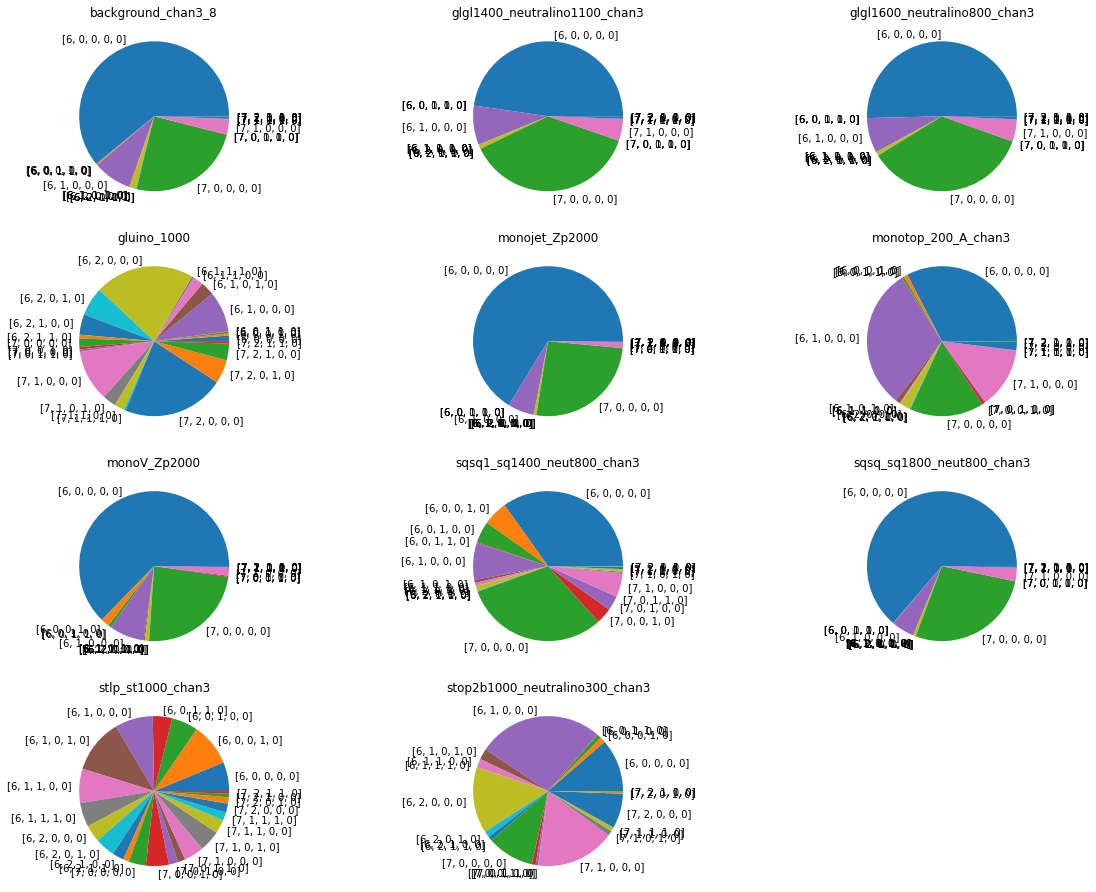

In [11]:
plt.figure(figsize=(20, 20))
i=0
for filename in files_to_process:
    filepath = "%s/%s" % (DATAPATH,filename)
    fevents = []
    labels = []
    for sel in selection:
        print(filepath, sel)
        df, totevts = process_file(filepath,sel)
        savefile(filename,sel,df)
        fevents += [df.shape[0]/totevts] # for pie-charts
        labels  += [sel]
        df = pd.DataFrame() # reset df to free memory
    plt.subplot(5,3,i+1)
    fevents += [1-np.sum(fevents)]
    labels += ['other']
    if (pienorm==False):
        plt.pie(fevents,labels=labels,normalize=False) # pie (fraction over total events)
    else:
        plt.pie(fevents[:-1],labels=labels[:-1],normalize=True) # pie (normalized fractions)
    plt.title(filename.split(sep='.')[0])
    i+=1

plt.savefig('images/pie-charts-chan1-norm-2.pdf')

# Evt yields

### Hackathon chan3

### Hackathon chan1